In [1]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import einops as ei
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Dropout(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        # Adjusting input dimensions: Flatten the last two dimensions
        batch_size, seq_len, channels, _ = x.size()
        x = x.view(batch_size, seq_len, -1)

        # Initialize hidden state with zeros
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(dtype=x.dtype,device=x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(dtype=x.dtype,device=x.device)

        # Forward propagate LSTM
        out, (h1, c1) = self.lstm(x, (h0, c0))

        # Decode the hidden state of each time step
        out = self.fc(out)
        
        # Reshape the output to match the target shape
        out = out.view(batch_size, seq_len, channels, -1)
        return out

In [2]:
file_path = './data/ETTm2.csv'
data = pd.read_csv(file_path)
data.head()
ot = data.values[:,-1].astype(np.float32)

In [3]:
class LSTMDataSet(Dataset):
    def __init__(self, 
                 data, 
                 seq_len,
                 pred_len, 
                 train=True, 
                 test_size=0.2):
        self.seq_len = seq_len
        self.pred_len = pred_len
       
        if train:
            self.data_, _, = train_test_split(data, test_size=test_size,shuffle=False)
        else:
            _, self.data_ = train_test_split(data, test_size=test_size,shuffle=False)
        self.data_fft = np.fft.fft(self.data_.astype(np.float32))
        self.data_len = self.data_fft.shape[0] - seq_len - pred_len - 1
        self.data_cat = np.expand_dims((self.data_fft.real,self.data_fft.imag),axis=1)
        self.data = ei.rearrange(self.data_cat, 'c s b -> b c s')

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        X = self.data[idx:idx+self.seq_len,:,:]
        y = self.data[idx+self.seq_len:idx+self.seq_len+self.pred_len,:,-1]
        return X, y

In [4]:
# Example usage
input_size = 1  # Example input size
hidden_size = 100
batch_size = 1024
seq_len = 96
pred_len = 32
lr = 1e-4
num_epochs = 1_000

trainset = LSTMDataSet(data=data.values[:,-1],seq_len=seq_len,pred_len=pred_len,train=True)
testset = LSTMDataSet(data=data.values[:,-1],seq_len=seq_len,pred_len=pred_len,train=False)
trainloader = DataLoader(trainset,batch_size=batch_size,shuffle=False)
testloader = DataLoader(testset,batch_size=batch_size,shuffle=False)
output_size = pred_len  # Example output size

# Create a random input tensor
ch=2
input_data = torch.randn(batch_size, seq_len, ch, input_size)

# Create the model
model = LSTMModel(input_size*ch, hidden_size, output_size*ch)

# Forward pass
output = model(input_data)
print("Output shape:", output.shape)  # Expected output shape: (batch_size, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Output shape: torch.Size([1024, 96, 2, 32])


LSTMModel(
  (lstm): LSTM(2, 100, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=100, out_features=64, bias=True)
  )
)

In [5]:
checkpoint = torch.load('./checkpoint1000.pth')
model.load_state_dict(checkpoint['state_dict'])
start_epoch = checkpoint['epoch']+1
train_log,test_log = np.zeros(start_epoch+num_epochs,),np.zeros(start_epoch+num_epochs,)
train_log[:start_epoch] = checkpoint['train_log']
test_log[:start_epoch] = checkpoint['test_log']

FileNotFoundError: [Errno 2] No such file or directory: './checkpoint1000.pth'

In [6]:
inputs.dtype

NameError: name 'inputs' is not defined

In [7]:
with tqdm(total=num_epochs) as pbar:
    pbar.update(0)
    for epoch in range(num_epochs):
        epoch_loss = 0
        model.train()
        for inputs_,targets_ in trainloader:
            inputs,targets = inputs_.to(device,torch.float64),targets_.to(device,torch.float64)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            batch_loss = loss.item()
            epoch_loss += batch_loss*inputs.size(0)
        epoch_loss /= trainset.__len__()
        model.eval()
        test_epoch_loss = 0
        for inputs_,targets_ in testloader:
            inputs,targets = inputs_.to(device),targets_.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            batch_loss = loss.item()
            test_epoch_loss += batch_loss*inputs.size(0)
        test_epoch_loss /= testset.__len__()
        train_log[start_epoch+epoch] = epoch_loss
        test_log[start_epoch+epoch] = test_epoch_loss
        pbar.set_postfix(train_loss=epoch_loss,test_loss=test_epoch_loss,epoch=start_epoch+epoch+1)
        pbar.update(1)
        

  0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: Input and parameter tensors are not the same dtype, found input tensor with Double and parameter tensor with Float

In [31]:
checkpoint = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'train_log': train_log,
    'test_log':test_log}
torch.save(checkpoint, f"checkpoint{start_epoch+epoch+1}.pth")

In [61]:
for inputs_,targets_ in trainloader:
    inputs,targets = inputs_.to(device),targets_.to(device)
    break

In [62]:
inputs.shape

torch.Size([32, 96, 7])

In [65]:
outputs = model(inputs)
output.shape

torch.Size([32, 96])

In [71]:
outputs = model(inputs)

In [74]:
inputs.shape,outputs.shape,targets.shape

(torch.Size([15, 96, 7]), torch.Size([15, 96]), torch.Size([15, 96]))

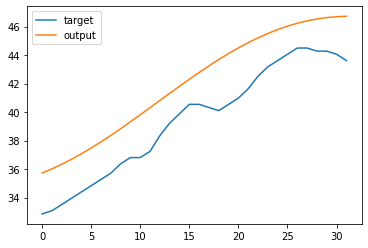

In [16]:
plt.plot(targets.cpu()[0])
plt.plot(outputs.detach().cpu()[0])
plt.legend(['target', 'output'])

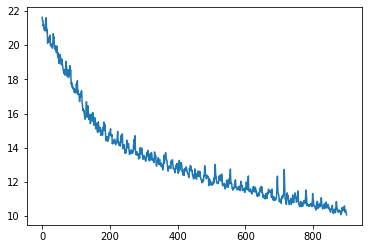

In [19]:
plt.plot(train_log[100:])

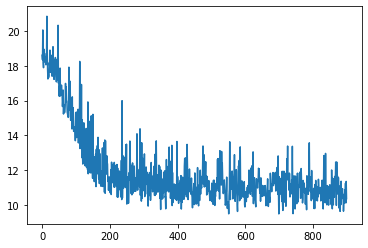

In [20]:
plt.plot(test_log[100:])